In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

from mlxtend.classifier import StackingClassifier
from tqdm import tqdm

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
import keras

C:\Users\tulasi ram\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [78]:
#after merging and preprocessed data
result = pd.read_csv('cancer_data',index_col=0)

In [79]:
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


**Splitting data into train, test and cross validation (64:20:16)**


In [4]:
y_true = result['Class'].values
result.Gene      = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')

# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [5]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    A =(((C.T)/(C.sum(axis=1))).T)
                   
    B =(C/C.sum(axis=0))
 
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

In [6]:
# code for response coding with Laplace smoothing.
# alpha : used for laplace smoothing
# feature: ['gene', 'variation']
# df: ['train_df', 'test_df', 'cv_df']
# get_gv_fea_dict: Get Gene varaition Feature Dict
def get_gv_fea_dict(alpha, feature, df):
    value_count = train_df[feature].value_counts()
    # gv_dict : Gene Variation Dict, which contains the probability array for each gene/variation
    gv_dict = dict()
    for i, denominator in value_count.items():
        vec = []
        for k in range(1,10):
            cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))

        # we are adding the gene/variation to the dict as key and vec as value
        gv_dict[i]=vec
    return gv_dict

# Get Gene variation feature
def get_gv_feature(alpha, feature, df):

    gv_dict = get_gv_fea_dict(alpha, feature, df)
    # value_count is similar in get_gv_fea_dict
    value_count = train_df[feature].value_counts()
    
    # gv_fea: Gene_variation feature, it will contain the feature for each feature value in the data
    gv_fea = []
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
#             gv_fea.append([-1,-1,-1,-1,-1,-1,-1,-1,-1])
    return gv_fea

In [7]:
### one-hot encoding of Gene feature.
gene_vectorizer = CountVectorizer(ngram_range=(1,2))
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

In [8]:
# one-hot encoding of variation feature.
variation_vectorizer = CountVectorizer(ngram_range=(1,2))
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

In [9]:
# building a TfidfVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df=3,ngram_range=(1,2))
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 773113


In [10]:
# normalizing every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])
#normalizing every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [11]:
# merging gene, variance and text features
train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))


In [12]:
def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [13]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

**Logistic Regression**

*With Class Balancing*

for alpha = 1e-06
Log Loss : 1.53298313437766
for alpha = 1e-05
Log Loss : 1.5464018591715154
for alpha = 0.0001
Log Loss : 1.543208771557003
for alpha = 0.001
Log Loss : 1.4616086103029957
for alpha = 0.01
Log Loss : 1.1759957762030604
for alpha = 0.1
Log Loss : 1.2022043275319736
for alpha = 1
Log Loss : 1.254903804227539
for alpha = 10
Log Loss : 1.3113137106070625
for alpha = 100
Log Loss : 1.325428127644812


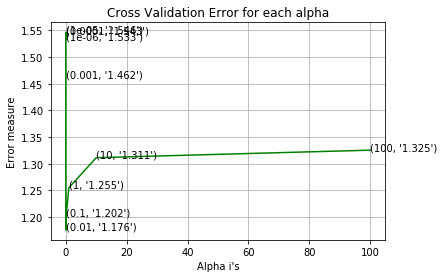

For values of best alpha =  0.01 The train log loss is: 0.8350900757184301
For values of best alpha =  0.01 The cross validation log loss is: 1.1759957762030604
For values of best alpha =  0.01 The test log loss is: 1.1924056222620378


In [14]:
#hyperparameter tuning
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

**Testing the model with best hyper paramters**

Log loss : 1.1759957762030604
Number of mis-classified points : 0.40789473684210525
-------------------- Confusion matrix --------------------


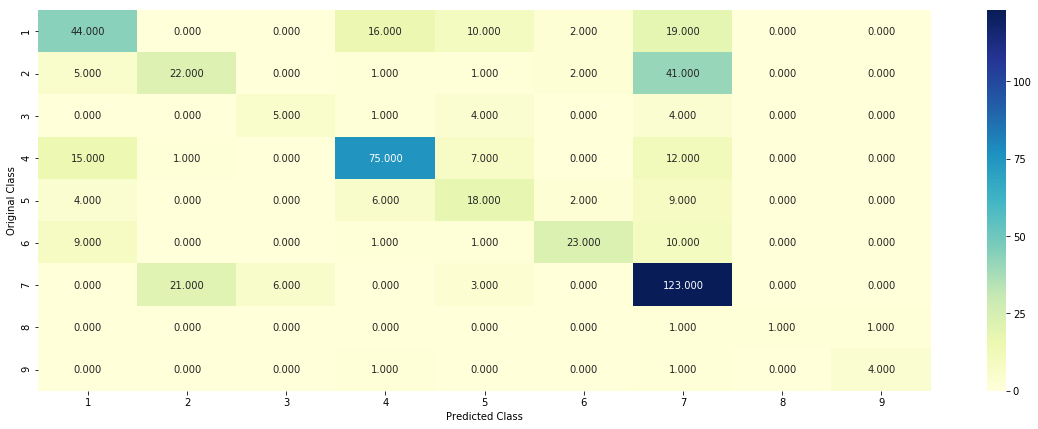

-------------------- Precision matrix (Columm Sum=1) --------------------


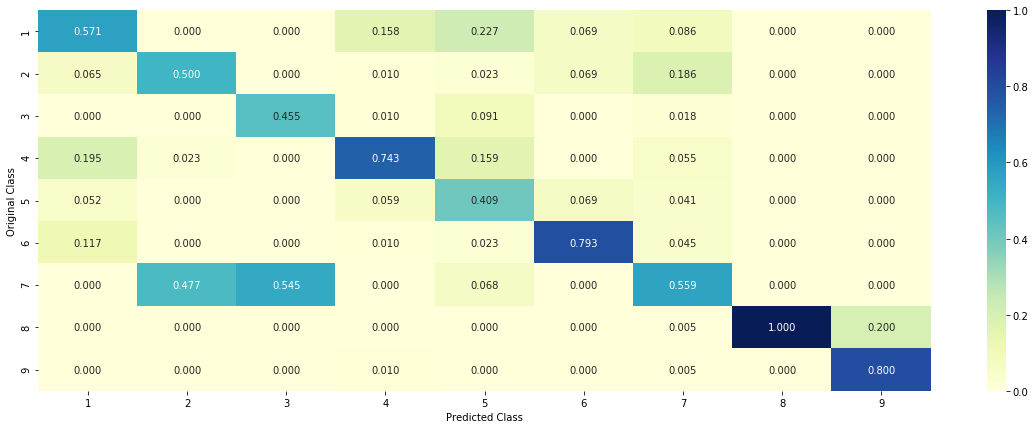

-------------------- Recall matrix (Row sum=1) --------------------


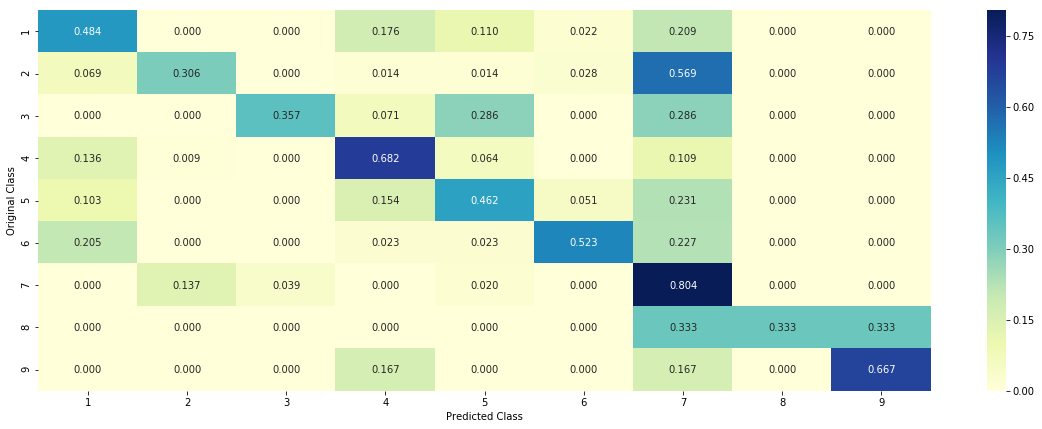

In [16]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

**INFERENCE**

*Log loss value is greater than the one with unigrams and the results are not much good.*

**ASSIGNMENT 4**

In [57]:
import tensorflow as tf
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer

In [13]:
def dictionary_paddle_text(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

In [16]:
text_dictionary = dictionary_paddle_text(result)

In [35]:
sorted_text_dictionary = dict()
for w in sorted(text_dictionary, key=text_dictionary.get, reverse=True):
    sorted_text_dictionary[w] = text_dictionary[w]

In [38]:
i =1
for k, v in sorted_text_dictionary.items():
    sorted_text_dictionary[k] = i
    i = i+1
    

In [41]:
i =0
for text_data in tqdm(result['TEXT'].values):
    words = text_data.split()
    result['TEXT'][i] = ' '.join(str(sorted_text_dictionary.get(word, word)) for word in words)
    i = i+1

100%|██████████████████████████████████████████████████████████████████████████████| 3321/3321 [03:39<00:00, 15.16it/s]


In [44]:
i = 0
for numbers in tqdm(result['TEXT'].values):
    list = []
    words = numbers.split(' ')
    for word in words:
        try:
            if int(word)<2000:
                list.append(word)
        except ValueError:
            continue
    result['TEXT'][i] = ' '.join(list)
    i = i+1

100%|██████████████████████████████████████████████████████████████████████████████| 3321/3321 [03:32<00:00, 15.62it/s]


In [76]:
len((result['TEXT'][30]))

652

In [49]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb.fit(result['Class'].values)

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

In [50]:
lb.classes_

array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

In [51]:
Y = lb.transform(result['Class'].values)

In [52]:
set(result['Class'].values)

{1, 2, 3, 4, 5, 6, 7, 8, 9}

In [53]:
Y[0]

array([1, 0, 0, 0, 0, 0, 0, 0, 0])

In [54]:
for i in range(result.shape[0]):
    result['TEXT'][i] = result['TEXT'][i].split()

In [55]:
X_train, X_test, Y_train, Y_test = train_test_split(result['TEXT'], Y, test_size=0.2 )

In [58]:
# truncate and/or pad input sequences
max_review_length = 5000
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)

print(X_train.shape)
print(X_train[1])

(2656, 5000)
[   0    0    0 ...   14   73 1588]


In [59]:
print(type(X_train[1]))
print(len(X_train[1]))

<class 'numpy.ndarray'>
5000


In [70]:
top_words = 2000
# create the model
embedding_vector_length = 32
model = Sequential()
model.add(Embedding(top_words, embedding_vector_length, input_length=5000))
model.add(LSTM(100,dropout=0.4))
model.add(Dense(9, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 5000, 32)          64000     
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 909       
Total params: 118,109
Trainable params: 118,109
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model.fit(X_train, Y_train, nb_epoch=10, batch_size=64)
# Final evaluation of the model
scores = model.evaluate(X_test, Y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/10
2656/2656 [==============================] - ETA: 17:49 - loss: 2.1891 - acc: 0.24 - ETA: 15:13 - loss: 2.1862 - acc: 0.23 - ETA: 13:18 - loss: 2.1825 - acc: 0.26 - ETA: 11:51 - loss: 2.1796 - acc: 0.26 - ETA: 10:40 - loss: 2.1745 - acc: 0.27 - ETA: 9:43 - loss: 2.1710 - acc: 0.2656 - ETA: 8:54 - loss: 2.1661 - acc: 0.262 - ETA: 8:12 - loss: 2.1569 - acc: 0.265 - ETA: 7:36 - loss: 2.1463 - acc: 0.270 - ETA: 7:04 - loss: 2.1332 - acc: 0.265 - ETA: 6:35 - loss: 2.1074 - acc: 0.272 - ETA: 6:09 - loss: 2.1023 - acc: 0.269 - ETA: 5:46 - loss: 2.0875 - acc: 0.273 - ETA: 5:25 - loss: 2.0749 - acc: 0.279 - ETA: 5:04 - loss: 2.0616 - acc: 0.282 - ETA: 4:45 - loss: 2.0523 - acc: 0.278 - ETA: 4:26 - loss: 2.0408 - acc: 0.278 - ETA: 4:09 - loss: 2.0335 - acc: 0.276 - ETA: 3:52 - loss: 2.0252 - acc: 0.275 - ETA: 3:36 - loss: 2.0198 - acc: 0.272 - ETA: 3:21 - loss: 2.0107 - acc: 0.271 - ETA: 3:06 - loss: 2.0014 - acc: 0.269 - ETA: 2:52 - loss: 1.9952 - acc: 0.265 - ETA: 2:38 - loss: 1.990

2656/2656 [==============================] - ETA: 7:31 - loss: 0.7328 - acc: 0.718 - ETA: 8:11 - loss: 0.7636 - acc: 0.718 - ETA: 7:27 - loss: 0.8727 - acc: 0.682 - ETA: 7:02 - loss: 0.8791 - acc: 0.675 - ETA: 6:43 - loss: 0.8714 - acc: 0.687 - ETA: 6:36 - loss: 0.8717 - acc: 0.687 - ETA: 6:21 - loss: 0.8575 - acc: 0.694 - ETA: 6:02 - loss: 0.8371 - acc: 0.705 - ETA: 5:49 - loss: 0.8439 - acc: 0.708 - ETA: 5:42 - loss: 0.8410 - acc: 0.714 - ETA: 5:33 - loss: 0.8441 - acc: 0.715 - ETA: 5:19 - loss: 0.8405 - acc: 0.714 - ETA: 5:05 - loss: 0.8429 - acc: 0.712 - ETA: 4:54 - loss: 0.8306 - acc: 0.716 - ETA: 4:42 - loss: 0.8307 - acc: 0.712 - ETA: 4:32 - loss: 0.8233 - acc: 0.715 - ETA: 4:22 - loss: 0.8262 - acc: 0.717 - ETA: 4:10 - loss: 0.8313 - acc: 0.716 - ETA: 3:58 - loss: 0.8371 - acc: 0.715 - ETA: 3:46 - loss: 0.8342 - acc: 0.711 - ETA: 3:35 - loss: 0.8294 - acc: 0.710 - ETA: 3:25 - loss: 0.8282 - acc: 0.712 - ETA: 3:15 - loss: 0.8260 - acc: 0.714 - ETA: 3:05 - loss: 0.8316 - acc: 0.7

In [24]:
model.fit(X_train, Y_train, nb_epoch=50, batch_size=64)
# Final evaluation of the model
scores = model.evaluate(X_test, Y_test, verbose=0)
print("Loss: %.2f%%" % (scores[0]))
print("Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/50
2656/2656 [==============================] - ETA: 4:41 - loss: 2.1984 - acc: 0.156 - ETA: 4:14 - loss: 2.1961 - acc: 0.179 - ETA: 4:02 - loss: 2.1937 - acc: 0.218 - ETA: 3:56 - loss: 2.1920 - acc: 0.234 - ETA: 3:50 - loss: 2.1900 - acc: 0.246 - ETA: 3:43 - loss: 2.1873 - acc: 0.260 - ETA: 3:37 - loss: 2.1854 - acc: 0.254 - ETA: 3:30 - loss: 2.1819 - acc: 0.257 - ETA: 3:23 - loss: 2.1787 - acc: 0.260 - ETA: 3:16 - loss: 2.1746 - acc: 0.265 - ETA: 3:10 - loss: 2.1708 - acc: 0.268 - ETA: 3:03 - loss: 2.1632 - acc: 0.277 - ETA: 2:57 - loss: 2.1545 - acc: 0.276 - ETA: 2:51 - loss: 2.1450 - acc: 0.275 - ETA: 2:45 - loss: 2.1312 - acc: 0.275 - ETA: 2:38 - loss: 2.1178 - acc: 0.277 - ETA: 2:32 - loss: 2.1066 - acc: 0.279 - ETA: 2:26 - loss: 2.0976 - acc: 0.276 - ETA: 2:20 - loss: 2.0829 - acc: 0.276 - ETA: 2:14 - loss: 2.0764 - acc: 0.272 - ETA: 2:08 - loss: 2.0688 - acc: 0.272 - ETA: 2:01 - loss: 2.0610 - acc: 0.274 - ETA: 1:55 - loss: 2.0530 - acc: 0.276 - ETA: 1:49 - loss: 2.0415

2656/2656 [==============================] - ETA: 4:53 - loss: 0.8190 - acc: 0.750 - ETA: 4:49 - loss: 0.7948 - acc: 0.757 - ETA: 4:46 - loss: 0.7635 - acc: 0.755 - ETA: 4:42 - loss: 0.7657 - acc: 0.730 - ETA: 4:38 - loss: 0.7632 - acc: 0.731 - ETA: 4:31 - loss: 0.7642 - acc: 0.742 - ETA: 4:24 - loss: 0.7648 - acc: 0.736 - ETA: 4:17 - loss: 0.7647 - acc: 0.736 - ETA: 4:10 - loss: 0.7623 - acc: 0.732 - ETA: 4:03 - loss: 0.7709 - acc: 0.725 - ETA: 3:55 - loss: 0.7651 - acc: 0.727 - ETA: 3:48 - loss: 0.7933 - acc: 0.717 - ETA: 3:40 - loss: 0.7896 - acc: 0.713 - ETA: 3:33 - loss: 0.7982 - acc: 0.708 - ETA: 3:25 - loss: 0.7986 - acc: 0.709 - ETA: 3:17 - loss: 0.7956 - acc: 0.713 - ETA: 3:09 - loss: 0.8016 - acc: 0.712 - ETA: 3:01 - loss: 0.7973 - acc: 0.714 - ETA: 2:54 - loss: 0.8117 - acc: 0.711 - ETA: 2:46 - loss: 0.8097 - acc: 0.716 - ETA: 2:38 - loss: 0.8117 - acc: 0.713 - ETA: 2:31 - loss: 0.8107 - acc: 0.715 - ETA: 2:23 - loss: 0.8097 - acc: 0.714 - ETA: 2:16 - loss: 0.8062 - acc: 0.7

2656/2656 [==============================] - ETA: 5:45 - loss: 0.3306 - acc: 0.890 - ETA: 5:39 - loss: 0.3931 - acc: 0.867 - ETA: 5:35 - loss: 0.4436 - acc: 0.854 - ETA: 5:23 - loss: 0.4978 - acc: 0.832 - ETA: 5:14 - loss: 0.5006 - acc: 0.825 - ETA: 5:05 - loss: 0.4870 - acc: 0.828 - ETA: 4:57 - loss: 0.4833 - acc: 0.825 - ETA: 4:48 - loss: 0.4999 - acc: 0.808 - ETA: 4:40 - loss: 0.5213 - acc: 0.795 - ETA: 4:31 - loss: 0.5122 - acc: 0.804 - ETA: 4:23 - loss: 0.5142 - acc: 0.805 - ETA: 4:14 - loss: 0.5150 - acc: 0.806 - ETA: 4:06 - loss: 0.5155 - acc: 0.807 - ETA: 3:58 - loss: 0.5114 - acc: 0.810 - ETA: 3:49 - loss: 0.5070 - acc: 0.810 - ETA: 3:41 - loss: 0.5079 - acc: 0.809 - ETA: 3:33 - loss: 0.5147 - acc: 0.807 - ETA: 3:24 - loss: 0.5119 - acc: 0.809 - ETA: 3:16 - loss: 0.5225 - acc: 0.802 - ETA: 3:07 - loss: 0.5245 - acc: 0.803 - ETA: 2:58 - loss: 0.5295 - acc: 0.800 - ETA: 2:50 - loss: 0.5347 - acc: 0.799 - ETA: 2:41 - loss: 0.5374 - acc: 0.800 - ETA: 2:32 - loss: 0.5390 - acc: 0.8

2656/2656 [==============================] - ETA: 5:56 - loss: 0.4772 - acc: 0.765 - ETA: 5:49 - loss: 0.4409 - acc: 0.796 - ETA: 5:40 - loss: 0.3908 - acc: 0.833 - ETA: 5:31 - loss: 0.3964 - acc: 0.835 - ETA: 5:22 - loss: 0.4147 - acc: 0.828 - ETA: 5:12 - loss: 0.4158 - acc: 0.822 - ETA: 5:02 - loss: 0.3951 - acc: 0.837 - ETA: 4:53 - loss: 0.4126 - acc: 0.828 - ETA: 4:45 - loss: 0.4200 - acc: 0.826 - ETA: 4:35 - loss: 0.4084 - acc: 0.834 - ETA: 4:26 - loss: 0.4096 - acc: 0.835 - ETA: 4:18 - loss: 0.4101 - acc: 0.837 - ETA: 4:10 - loss: 0.4022 - acc: 0.837 - ETA: 4:01 - loss: 0.4207 - acc: 0.835 - ETA: 3:53 - loss: 0.4161 - acc: 0.836 - ETA: 3:44 - loss: 0.4170 - acc: 0.836 - ETA: 3:36 - loss: 0.4282 - acc: 0.831 - ETA: 3:27 - loss: 0.4238 - acc: 0.831 - ETA: 3:18 - loss: 0.4212 - acc: 0.833 - ETA: 3:09 - loss: 0.4272 - acc: 0.832 - ETA: 3:01 - loss: 0.4261 - acc: 0.830 - ETA: 2:52 - loss: 0.4277 - acc: 0.828 - ETA: 2:43 - loss: 0.4331 - acc: 0.826 - ETA: 2:35 - loss: 0.4355 - acc: 0.8

2656/2656 [==============================] - ETA: 5:55 - loss: 0.4717 - acc: 0.765 - ETA: 5:48 - loss: 0.4527 - acc: 0.796 - ETA: 5:39 - loss: 0.4401 - acc: 0.817 - ETA: 5:30 - loss: 0.4229 - acc: 0.816 - ETA: 5:22 - loss: 0.4035 - acc: 0.831 - ETA: 5:14 - loss: 0.3984 - acc: 0.833 - ETA: 5:05 - loss: 0.4189 - acc: 0.823 - ETA: 4:57 - loss: 0.4294 - acc: 0.816 - ETA: 4:48 - loss: 0.4241 - acc: 0.817 - ETA: 4:40 - loss: 0.4219 - acc: 0.818 - ETA: 4:31 - loss: 0.4278 - acc: 0.813 - ETA: 4:23 - loss: 0.4280 - acc: 0.813 - ETA: 4:14 - loss: 0.4276 - acc: 0.810 - ETA: 4:05 - loss: 0.4322 - acc: 0.805 - ETA: 3:57 - loss: 0.4227 - acc: 0.812 - ETA: 3:48 - loss: 0.4300 - acc: 0.811 - ETA: 3:39 - loss: 0.4273 - acc: 0.813 - ETA: 3:30 - loss: 0.4308 - acc: 0.809 - ETA: 3:21 - loss: 0.4271 - acc: 0.811 - ETA: 3:12 - loss: 0.4364 - acc: 0.809 - ETA: 3:03 - loss: 0.4312 - acc: 0.813 - ETA: 2:54 - loss: 0.4339 - acc: 0.811 - ETA: 2:45 - loss: 0.4303 - acc: 0.813 - ETA: 2:36 - loss: 0.4242 - acc: 0.8

2656/2656 [==============================] - ETA: 6:15 - loss: 0.4300 - acc: 0.796 - ETA: 6:10 - loss: 0.3610 - acc: 0.843 - ETA: 5:59 - loss: 0.3734 - acc: 0.838 - ETA: 5:48 - loss: 0.3749 - acc: 0.832 - ETA: 5:40 - loss: 0.3749 - acc: 0.825 - ETA: 5:30 - loss: 0.3555 - acc: 0.835 - ETA: 5:22 - loss: 0.3830 - acc: 0.821 - ETA: 5:13 - loss: 0.3938 - acc: 0.822 - ETA: 5:04 - loss: 0.3942 - acc: 0.824 - ETA: 4:55 - loss: 0.3769 - acc: 0.837 - ETA: 4:47 - loss: 0.3902 - acc: 0.826 - ETA: 4:38 - loss: 0.3974 - acc: 0.824 - ETA: 4:29 - loss: 0.3949 - acc: 0.825 - ETA: 4:20 - loss: 0.3837 - acc: 0.829 - ETA: 4:12 - loss: 0.3809 - acc: 0.831 - ETA: 4:02 - loss: 0.3919 - acc: 0.825 - ETA: 3:53 - loss: 0.3870 - acc: 0.828 - ETA: 3:44 - loss: 0.3857 - acc: 0.829 - ETA: 3:34 - loss: 0.3945 - acc: 0.825 - ETA: 3:25 - loss: 0.3976 - acc: 0.824 - ETA: 3:15 - loss: 0.4009 - acc: 0.822 - ETA: 3:05 - loss: 0.3993 - acc: 0.822 - ETA: 2:56 - loss: 0.4060 - acc: 0.817 - ETA: 2:46 - loss: 0.4043 - acc: 0.8

2656/2656 [==============================] - ETA: 6:44 - loss: 0.3671 - acc: 0.843 - ETA: 6:36 - loss: 0.4031 - acc: 0.828 - ETA: 6:24 - loss: 0.4088 - acc: 0.828 - ETA: 6:16 - loss: 0.3866 - acc: 0.843 - ETA: 6:08 - loss: 0.3901 - acc: 0.840 - ETA: 5:59 - loss: 0.4037 - acc: 0.822 - ETA: 5:49 - loss: 0.4017 - acc: 0.821 - ETA: 5:39 - loss: 0.3943 - acc: 0.824 - ETA: 5:29 - loss: 0.3916 - acc: 0.826 - ETA: 5:19 - loss: 0.4054 - acc: 0.820 - ETA: 5:10 - loss: 0.3990 - acc: 0.823 - ETA: 4:59 - loss: 0.4085 - acc: 0.819 - ETA: 4:49 - loss: 0.4099 - acc: 0.820 - ETA: 4:38 - loss: 0.4050 - acc: 0.822 - ETA: 4:28 - loss: 0.4058 - acc: 0.821 - ETA: 4:17 - loss: 0.4077 - acc: 0.822 - ETA: 4:07 - loss: 0.4048 - acc: 0.823 - ETA: 3:57 - loss: 0.4092 - acc: 0.821 - ETA: 3:48 - loss: 0.4041 - acc: 0.822 - ETA: 3:37 - loss: 0.4070 - acc: 0.820 - ETA: 3:27 - loss: 0.4057 - acc: 0.820 - ETA: 3:17 - loss: 0.4101 - acc: 0.818 - ETA: 3:07 - loss: 0.4119 - acc: 0.820 - ETA: 2:58 - loss: 0.4221 - acc: 0.8